In [1]:
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.auto import trange
from contextlib import redirect_stdout

import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps, plot_layer_head_score_summary
from utils.attention_analysis_lib import *
from utils.cv2_eval_utils import find_classify_object_masks
from utils.obj_mask_utils import *
from circuit_toolkit.plot_utils import saveallforms

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [2]:
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
# if text_encoder_type == "T5":
text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.bfloat16, )

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
text_encoder = text_encoder.to(device="cuda", dtype=torch.bfloat16)

In [13]:
input_ids = tokenizer.encode("red circle on top of a blue square", return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(input_ids.to(device="cuda"))[0]

In [14]:
[tokenizer.decode(ids) for ids in input_ids[0]]

['red', 'circle', 'on', 'top', 'of', '', 'a', 'blue', 'square', '</s>']

In [15]:
text_embeddings.shape

torch.Size([1, 10, 4096])

In [16]:
input_ids = tokenizer.encode("blue square on top of a red circle", return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(input_ids.to(device="cuda"))[0]

In [46]:
from inspect import getsource
print(getsource(text_encoder.encoder.forward))

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        cache_position=None,
    ):
        # Model parallel
        if self.model_parallel:
            torch.cuda.set_device(self.first_device)
            self.embed_tokens = self.embed_tokens.to(self.first_device)
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_d

In [ ]:
prompts = [
    "blue square on top of a red circle",
    "red circle on top of a blue square",
    "blue square below a red circle",
    "red circle below a blue square",
    "blue triangle on top of a red circle",
    "red circle on top of a blue triangle",
    "blue triangle below a red circle",
    "red circle below a blue triangle",
    "blue square on top of a red circle",
    "red circle on top of a blue square",
    "blue square below a red circle",
    "red circle below a blue square",
    "blue triangle on top of a red circle",
    "red circle on top of a blue triangle",
    "blue triangle below a red circle",
    "red circle below a blue triangle",
]

# Process and embed all prompts using tokenizer's batch encoding
input_ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)["input_ids"]

with torch.no_grad():
    # raw_text_embeddings = text_encoder.shared(input_ids.to(device="cuda")).float()
    raw_text_embeddings = text_encoder.encoder.embed_tokens(input_ids.to(device="cuda")).float()
    text_embeddings = text_encoder(input_ids.to(device="cuda"))[0].float()
# 
# text_embeddings.shape


In [50]:
from torch.nn.functional import cosine_similarity
cosine_similarity(text_embeddings[1,:], raw_text_embeddings[1,:])

tensor([0.2457, 0.1973, 0.1106, 0.1787, 0.0238, 0.0044, 0.0592, 0.2609, 0.2079,
        0.0020], device='cuda:0')

In [ ]:
from torch.nn.functional import cosine_similarity
cosine_similarity(text_embeddings[1,:], raw_text_embeddings[1,:])

In [53]:
from torch.nn.functional import cosine_similarity
print([tokenizer.decode(ids) for ids in input_ids[0]])
print([tokenizer.decode(ids) for ids in input_ids[1]])
cosine_similarity(text_embeddings[0,:], text_embeddings[1,:])

['blue', 'square', 'on', 'top', 'of', '', 'a', 'red', 'circle', '</s>']
['red', 'circle', 'on', 'top', 'of', '', 'a', 'blue', 'square', '</s>']


tensor([ 0.7052,  0.6698,  0.8784,  0.9322,  0.8307,  0.9961, -0.3083,  0.7032,
         0.6704,  0.9999], device='cuda:0')

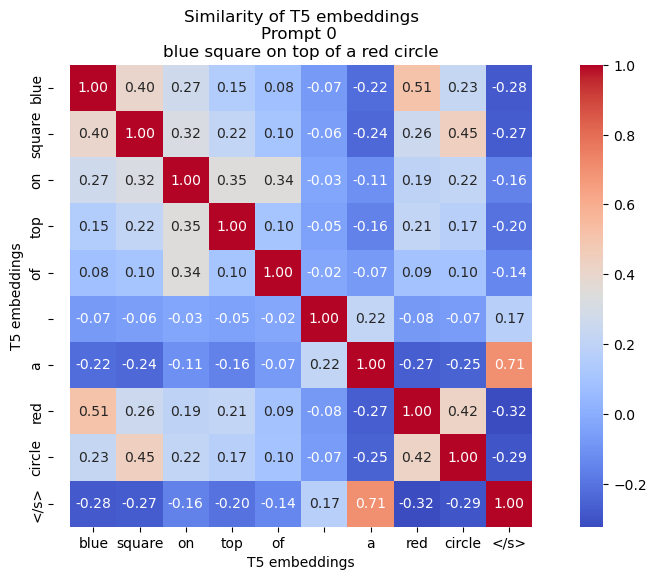

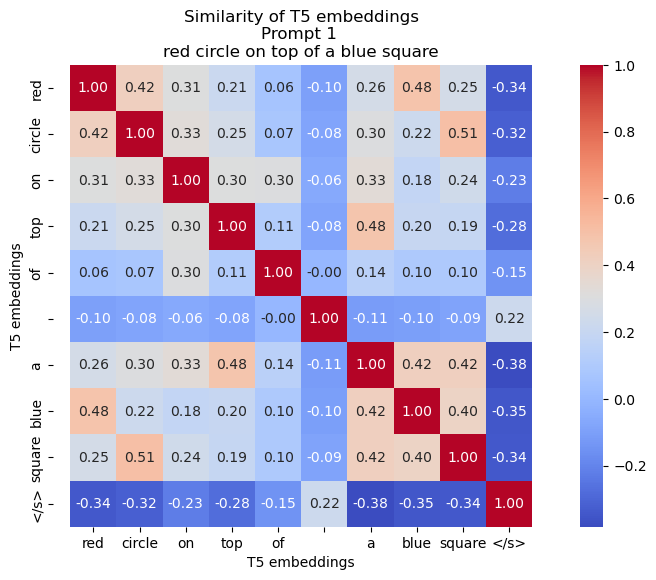

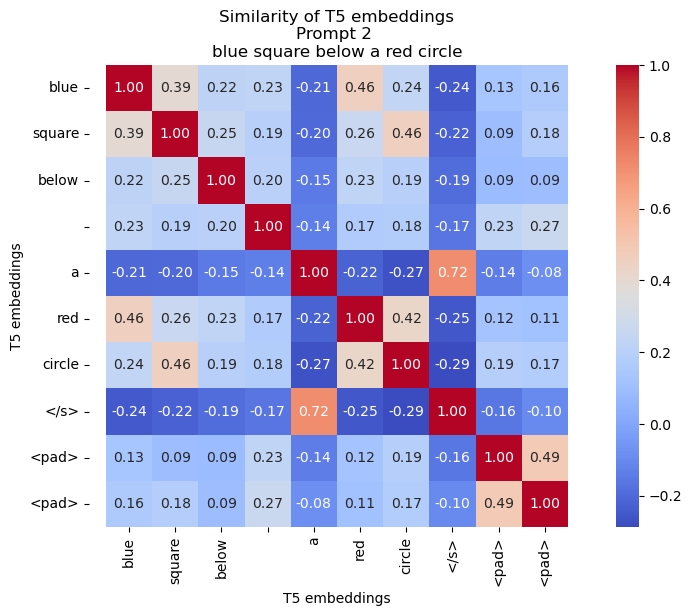

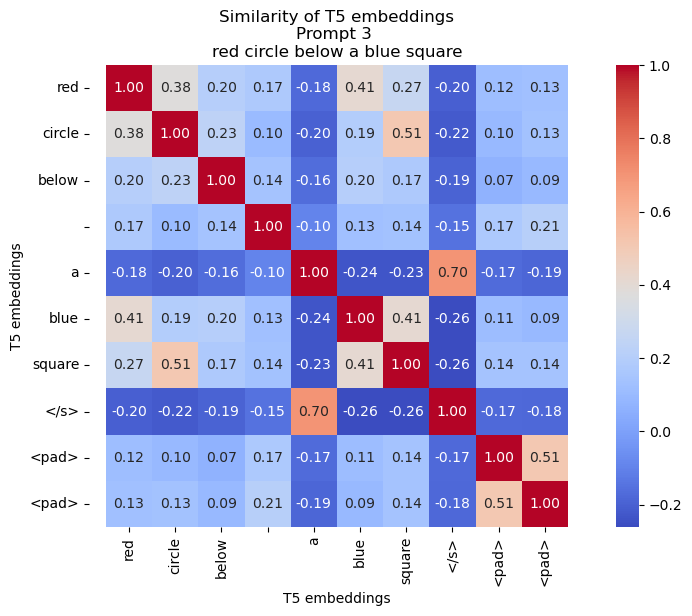

In [86]:
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
for prompt_i in range(4):
    cossim_mat = F.normalize(text_embeddings[prompt_i,:], dim=-1) @ F.normalize(text_embeddings[prompt_i,:], dim=-1).T
    seq1_tokens =[tokenizer.decode(ids) for ids in input_ids[prompt_i]]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cossim_mat.cpu(), annot=True, fmt=".2f", cmap="coolwarm", xticklabels=seq1_tokens, yticklabels=seq1_tokens)
    plt.axis('equal')
    plt.ylabel("T5 embeddings")
    plt.xlabel("T5 embeddings")
    plt.title(f"Similarity of T5 embeddings\nPrompt {prompt_i} \n{prompts[prompt_i]}")
    plt.show()

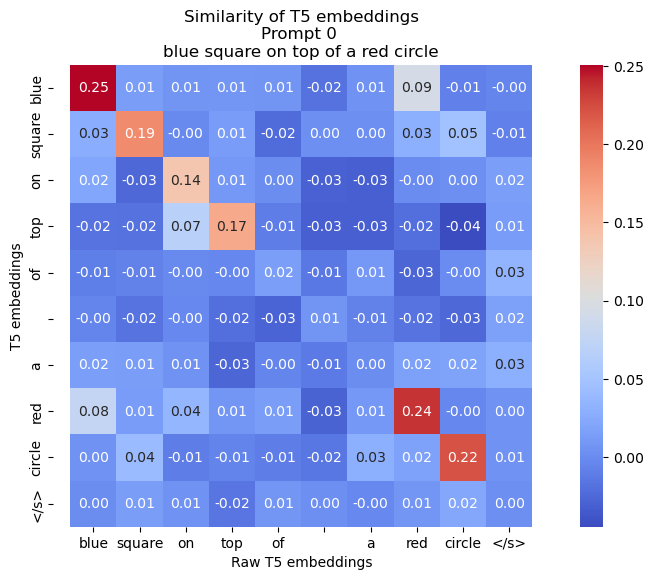

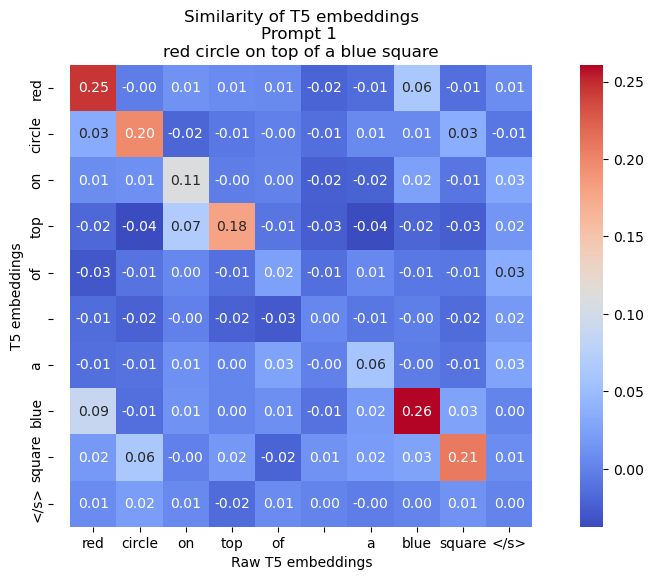

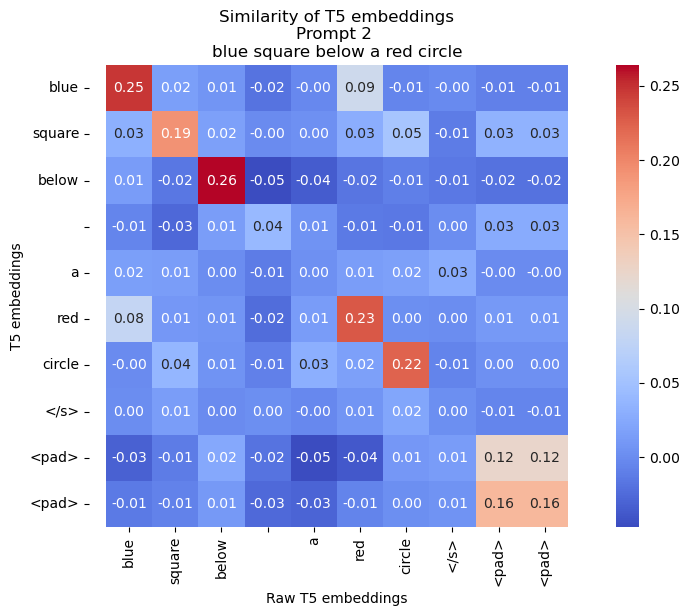

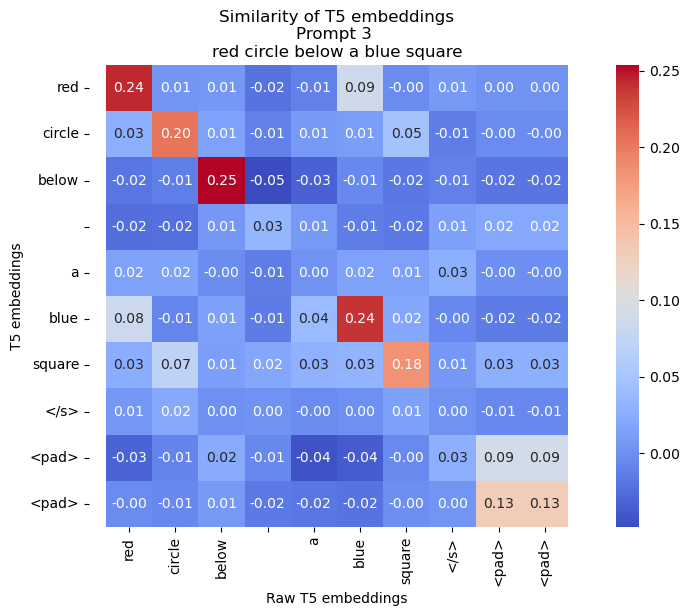

In [74]:
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
for prompt_i in range(4):
    cossim_mat = F.normalize(text_embeddings[prompt_i,:], dim=-1) @ F.normalize(raw_text_embeddings[prompt_i,:], dim=-1).T
    seq1_tokens =[tokenizer.decode(ids) for ids in input_ids[prompt_i]]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cossim_mat.cpu(), annot=True, fmt=".2f", cmap="coolwarm", xticklabels=seq1_tokens, yticklabels=seq1_tokens)
    plt.axis('equal')
    plt.ylabel("T5 embeddings")
    plt.xlabel("Raw T5 embeddings")
    plt.title(f"Similarity of T5 embeddings\nPrompt {prompt_i} \n{prompts[prompt_i]}")
    plt.show()

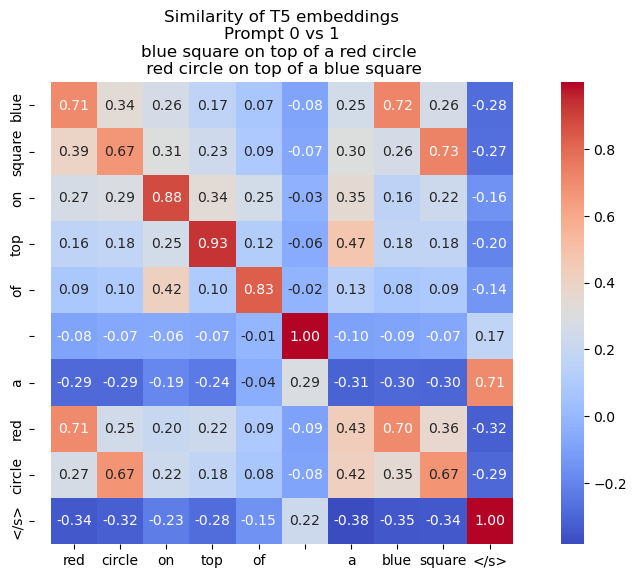

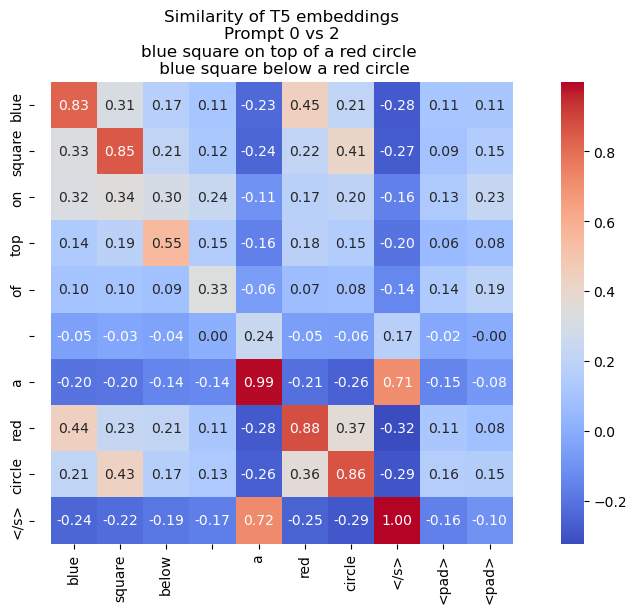

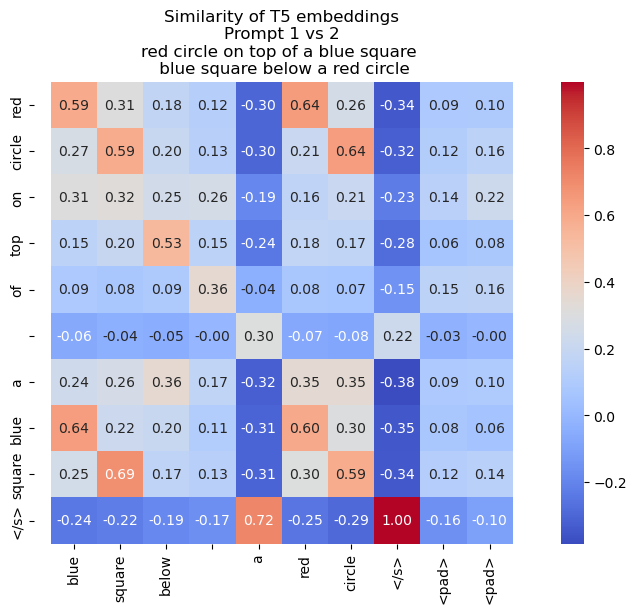

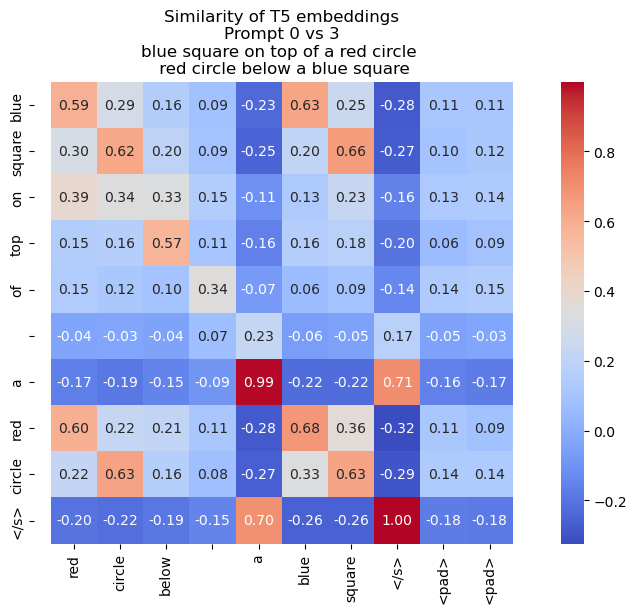

In [71]:
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
prompt_i, prompt_j = 0, 2
for prompt_i, prompt_j in [(0, 1), (0, 2), (1, 2), (0, 3)]:
    cossim_mat = F.normalize(text_embeddings[prompt_i,:], dim=-1) @ F.normalize(text_embeddings[prompt_j,:], dim=-1).T
    seq1_tokens =[tokenizer.decode(ids) for ids in input_ids[prompt_i]]
    seq2_tokens =[tokenizer.decode(ids) for ids in input_ids[prompt_j]]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cossim_mat.cpu(), annot=True, fmt=".2f", cmap="coolwarm", xticklabels=seq2_tokens, yticklabels=seq1_tokens)
    plt.axis('equal')
    plt.title(f"Similarity of T5 embeddings\nPrompt {prompt_i} vs {prompt_j}\n{prompts[prompt_i]} \n {prompts[prompt_j]}")
    plt.show()

In [75]:
prompts

['blue square on top of a red circle',
 'red circle on top of a blue square',
 'blue square below a red circle',
 'red circle below a blue square',
 'blue triangle on top of a red circle',
 'red circle on top of a blue triangle',
 'blue triangle below a red circle',
 'red circle below a blue triangle']

In [ ]:
pairs = [(0,2), (1,3), (4,6), (5,7)]
diff_emb = []
for prompt_i, prompt_j in pairs:
    diff_emb.append(text_embeddings[prompt_i,:2] - text_embeddings[prompt_j,:2])

diff_emb = torch.cat(diff_emb, dim=0)
diff_emb.shape

torch.Size([8, 4096])

In [84]:
for pair_i, pair_j in pairs:
    print(pair_i, pair_j)
    print(prompts[pair_i], '|', prompts[pair_j])

0 2
blue square on top of a red circle | blue square below a red circle
1 3
red circle on top of a blue square | red circle below a blue square
4 6
blue triangle on top of a red circle | blue triangle below a red circle
5 7
red circle on top of a blue triangle | red circle below a blue triangle


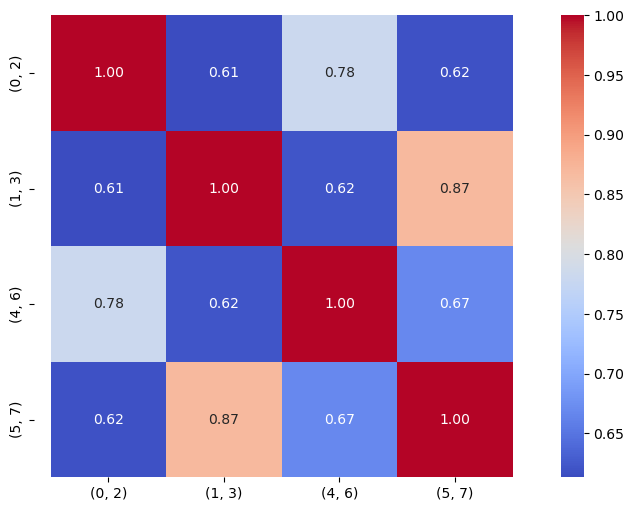

In [81]:
cossim_diff = F.normalize(diff_emb[::2], dim=-1) @ F.normalize(diff_emb[::2], dim=-1).T
plt.figure(figsize=(8, 6))
sns.heatmap(cossim_diff.cpu(), annot=True, fmt=".2f", cmap="coolwarm", xticklabels=pairs, yticklabels=pairs)
plt.axis('equal')
# plt.title(f"Similarity of non-contextualized T5 embeddings\nPrompt {prompt_i} vs {prompt_j}\n{prompts[prompt_i]} \n {prompts[prompt_j]}")
plt.show()

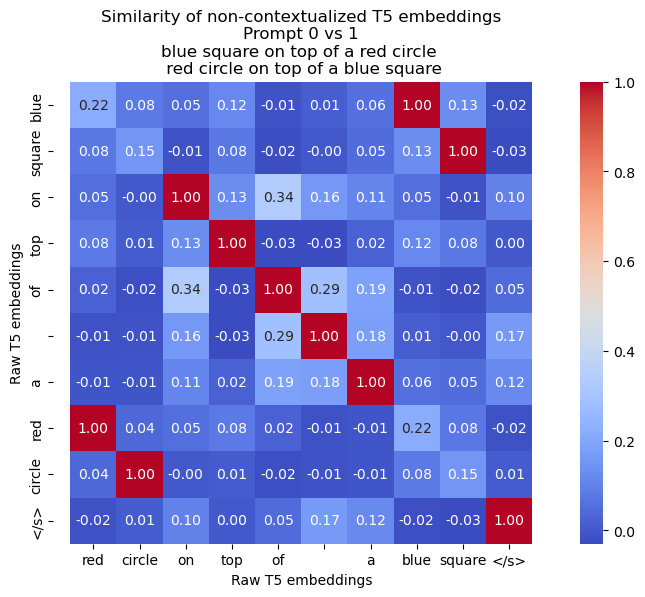

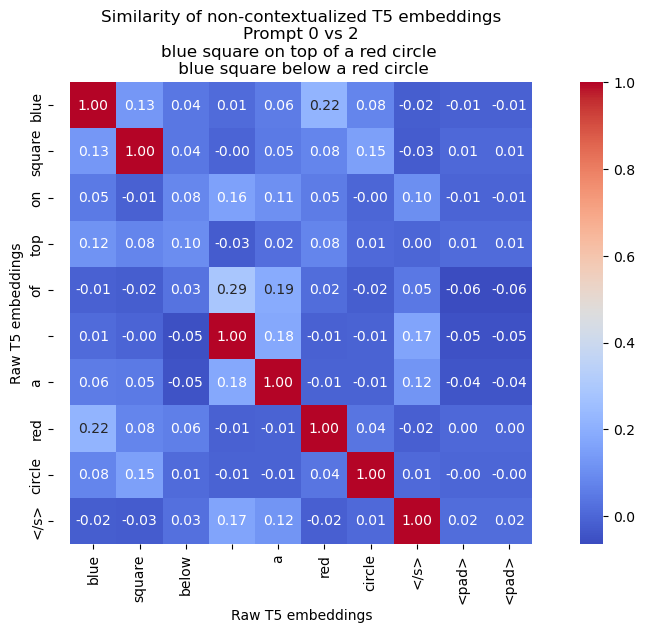

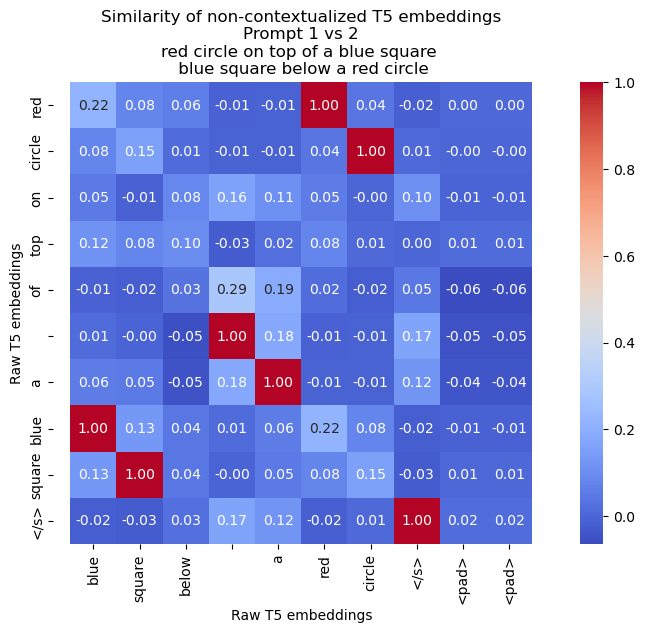

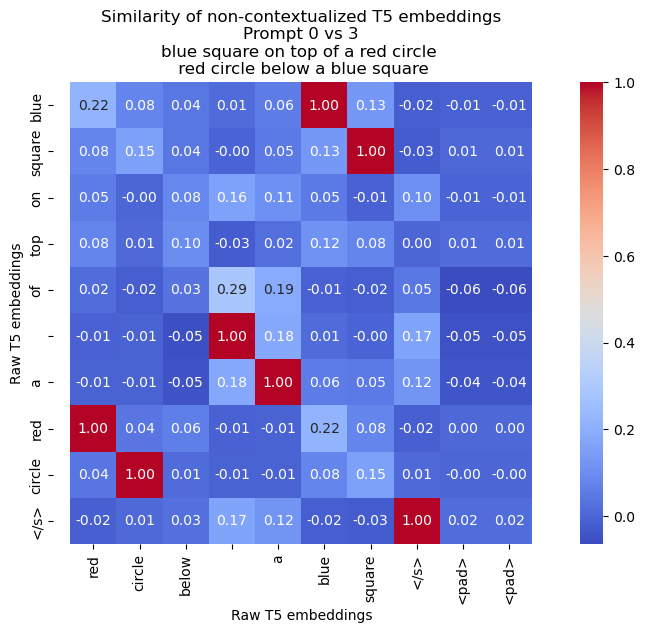

In [87]:
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
prompt_i, prompt_j = 0, 2
for prompt_i, prompt_j in [(0, 1), (0, 2), (1, 2), (0, 3)]:
    cossim_mat = F.normalize(raw_text_embeddings[prompt_i,:], dim=-1) @ F.normalize(raw_text_embeddings[prompt_j,:], dim=-1).T
    seq1_tokens =[tokenizer.decode(ids) for ids in input_ids[prompt_i]]
    seq2_tokens =[tokenizer.decode(ids) for ids in input_ids[prompt_j]]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cossim_mat.cpu(), annot=True, fmt=".2f", cmap="coolwarm", xticklabels=seq2_tokens, yticklabels=seq1_tokens)
    plt.axis('equal')
    plt.ylabel("Raw T5 embeddings")
    plt.xlabel("Raw T5 embeddings")
    plt.title(f"Similarity of non-contextualized T5 embeddings\nPrompt {prompt_i} vs {prompt_j}\n{prompts[prompt_i]} \n {prompts[prompt_j]}")
    plt.show()

In [39]:
text_embeddings.norm(dim=-1)

tensor([[7.0864, 7.3466, 6.4998, 7.1344, 5.0443, 2.8280, 2.0718, 7.1975, 7.7684,
         2.5986],
        [7.1484, 7.3564, 6.2668, 7.0957, 4.1507, 2.6564, 6.8988, 7.1276, 7.5811,
         2.5938],
        [6.4980, 7.1694, 6.3686, 5.4961, 2.1546, 6.7441, 7.4944, 2.5996, 6.4790,
         6.6265],
        [6.6141, 6.7120, 6.5924, 4.9610, 2.2228, 7.6526, 7.5114, 2.6136, 7.0552,
         6.9964],
        [7.1488, 7.4629, 6.4932, 7.1565, 4.5447, 7.0033, 2.1859, 7.1402, 7.8151,
         2.5965],
        [7.2875, 8.0427, 6.5012, 7.1945, 3.8453, 7.1019, 7.3123, 7.2269, 7.9245,
         2.5965],
        [6.6897, 6.8081, 6.5351, 2.6850, 2.0783, 7.0870, 7.7418, 2.5984, 7.8384,
         7.8067],
        [6.6414, 6.9286, 6.5266, 4.9946, 2.1787, 7.5615, 7.8435, 2.6125, 7.6664,
         7.2089]], device='cuda:0')

In [40]:
raw_text_embeddings.norm(dim=-1)

tensor([[394.6035, 406.3428, 230.9386, 321.0373, 205.7045, 265.7239, 237.4326,
         374.0268, 422.7080, 407.5308],
        [374.0268, 422.7080, 230.9386, 321.0373, 205.7045, 265.7239, 237.4326,
         394.6035, 406.3428, 407.5308],
        [394.6035, 406.3428, 348.1686, 265.7239, 237.4326, 374.0268, 422.7080,
         407.5308, 368.2474, 368.2474],
        [374.0268, 422.7080, 348.1686, 265.7239, 237.4326, 394.6035, 406.3428,
         407.5308, 368.2474, 368.2474],
        [394.6035, 541.4474, 230.9386, 321.0373, 205.7045, 265.7239, 237.4326,
         374.0268, 422.7080, 407.5308],
        [374.0268, 422.7080, 230.9386, 321.0373, 205.7045, 265.7239, 237.4326,
         394.6035, 541.4474, 407.5308],
        [394.6035, 541.4474, 348.1686, 265.7239, 237.4326, 374.0268, 422.7080,
         407.5308, 368.2474, 368.2474],
        [374.0268, 422.7080, 348.1686, 265.7239, 237.4326, 394.6035, 541.4474,
         407.5308, 368.2474, 368.2474]], device='cuda:0')

In [38]:
((text_embeddings - raw_text_embeddings).norm(dim=-1) / text_embeddings.norm(dim=-1))

tensor([[ 55.4420,  55.1321,  35.4057,  44.8441,  40.7763,  93.9601, 114.6064,
          51.7396,  54.2008, 156.8296],
        [ 52.0865,  57.2721,  36.7538,  45.0762,  49.5459, 100.0311,  34.3720,
          55.1104,  53.4002, 157.1174],
        [ 60.4879,  56.4936,  54.4142,  48.3169, 110.2003,  55.2393,  56.1891,
         156.7651,  56.7224,  55.4211],
        [ 56.3149,  62.7812,  52.5690,  53.5384, 106.8185,  51.3351,  53.9226,
         155.9259,  52.1138,  52.5123],
        [ 54.9516,  72.3234,  35.4633,  44.7001,  45.2565,  37.9280, 108.6286,
          52.1482,  53.8709, 156.9539],
        [ 51.0788,  52.3700,  35.4230,  44.4596,  53.4824,  37.3998,  32.4295,
          54.3434,  68.0998, 156.9544],
        [ 58.7738,  79.3010,  53.0275,  98.9646, 114.2443,  52.5494,  54.3924,
         156.8387,  46.8785,  47.0526],
        [ 56.0769,  60.8232,  53.1006,  53.1763, 108.9797,  51.9424,  68.8040,
         155.9941,  47.9555,  50.9775]], device='cuda:0')

In [29]:

# Quantify how much raw_text_embeddings explain text_embeddings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Reshape for sklearn (samples x features)
raw_embeddings_flat = raw_text_embeddings.cpu().numpy().reshape(-1, raw_text_embeddings.shape[-1])
processed_embeddings_flat = text_embeddings.cpu().numpy().reshape(-1, text_embeddings.shape[-1])

# Fit linear regression to see how well raw embeddings predict processed embeddings
reg = LinearRegression()
reg.fit(raw_embeddings_flat, processed_embeddings_flat)

# Calculate R² score
r2 = r2_score(processed_embeddings_flat, reg.predict(raw_embeddings_flat))
print(f"R² score (how much raw embeddings explain processed embeddings): {r2:.4f}")

# Calculate correlation coefficient for each dimension
correlations = []
for i in range(raw_embeddings_flat.shape[1]):
    corr = np.corrcoef(raw_embeddings_flat[:, i], processed_embeddings_flat[:, i])[0, 1]
    correlations.append(corr)

mean_correlation = np.mean(correlations)
print(f"Mean per-dimension correlation: {mean_correlation:.4f}")
print(f"Min correlation: {np.min(correlations):.4f}")
print(f"Max correlation: {np.max(correlations):.4f}")

# Calculate cosine similarity between corresponding embeddings
from torch.nn.functional import cosine_similarity
cos_sims = []
for i in range(raw_text_embeddings.shape[0]):
    for j in range(raw_text_embeddings.shape[1]):
        cos_sim = cosine_similarity(
            raw_text_embeddings[i, j].unsqueeze(0), 
            text_embeddings[i, j].unsqueeze(0)
        )
        cos_sims.append(cos_sim.item())

mean_cosine_sim = np.mean(cos_sims)
print(f"Mean cosine similarity between raw and processed embeddings: {mean_cosine_sim:.4f}")


R² score (how much raw embeddings explain processed embeddings): 0.6362
Mean per-dimension correlation: 0.1661
Min correlation: -0.7610
Max correlation: 0.9091
Mean cosine similarity between raw and processed embeddings: 0.1359


In [ ]:
with torch.no_grad():
    raw_text_embeddings = text_encoder.shared(input_ids.to(device="cuda"))
    raw_text_embeddings2 = text_encoder.encoder.embed_tokens(input_ids.to(device="cuda"))

assert torch.allclose(raw_text_embeddings, raw_text_embeddings2)

torch.Size([8, 10, 4096])

In [ ]:
text_encoder

T5EncoderModel(
  (shared): Embedding(32128, 4096)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 4096)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=4096, out_features=4096, bias=False)
              (k): Linear(in_features=4096, out_features=4096, bias=False)
              (v): Linear(in_features=4096, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=4096, bias=False)
              (relative_attention_bias): Embedding(32, 64)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=4096, out_features=10240, bias=False)
              (wi_1): Linear(in_features=4096, out_features=10240, bias=False)
              (wo